In [1]:
# Read trajectory data

import numpy as np
from msmbuilder.example_datasets import FsPeptide
from msmbuilder.dataset import dataset
import mdtraj as md

fs_peptide = FsPeptide()
fs_peptide.cache()
xyz = dataset(fs_peptide.data_dir + "/*.xtc",
              topology=fs_peptide.data_dir + '/fs-peptide.pdb',
              stride=10)

temp = xyz[0]
_, num_atoms, num_axis = temp.xyz.shape
reference_frame = temp.slice(0, copy=True)
num_features = num_atoms*num_axis;
pre_X = [np.reshape(traj.xyz, (traj.superpose(reference_frame).xyz.shape[0],num_features)) for traj in xyz]
X = np.concatenate(pre_X)
num_frames = X.shape[0]

C:\Anaconda2\lib\site-packages\mdtraj\formats\pdb\pdbfile.py:196: UserWarning: Unlikely unit cell vectors detected in PDB file likely resulting from a dummy CRYST1 record. Discarding unit cell vectors.
  warnings.warn('Unlikely unit cell vectors detected in PDB file likely '


In [2]:
# Load isomap data

# Load isomap cluster labels
# Ensure that the smallest cluster label is 0!
iso_label = np.load('./sherlock_data/isomap_clustering_labels_30_40_97.dat')

# Load isomap coordinate
iso_coord = np.load('./sherlock_data/isomap_coordinates_30_40_97.dat')

# Load isomap cluster centroids
iso_cent = np.load('./sherlock_data/isomap_clusters_RD_30_40_97.dat')

# Load raw X,Y,Z

In [3]:
# create cluster adjacency matrix

cluster_num = len(np.unique(iso_label))
n = 4
cluster_adj = np.zeros((cluster_num, cluster_num))

# create full adjacency matrix
for i in range(0,cluster_num-1):
    for j in range(i+1, cluster_num):
        cluster_adj[i,j] = np.linalg.norm(iso_cent[i]-iso_cent[j])

cluster_adj = cluster_adj + np.transpose(cluster_adj)
# prunce adjacency matrix
for i in range(0, cluster_num):
    ind = np.argpartition(cluster_adj[i], -cluster_num+n+1)[-cluster_num+n+1:]
    for j in ind:
        cluster_adj[i,j] = 0



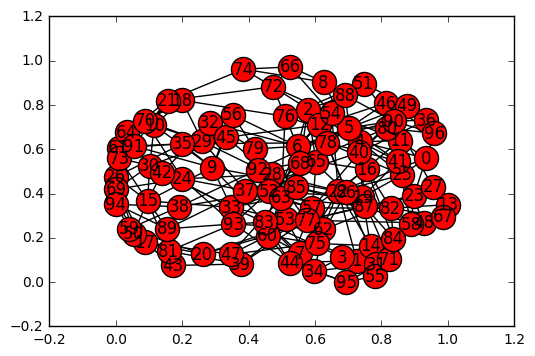

In [4]:
#visualize how the clusters are connected

def show_graph(adjacency_matrix):
    # given an adjacency matrix use networkx and matlpotlib to plot the graph
    import networkx as nx
    import matplotlib.pyplot as plt

    rows, cols = np.where(adjacency_matrix > 0)
    edges = zip(rows.tolist(), cols.tolist())
    gr = nx.Graph()
    gr.add_edges_from(edges)
    # nx.draw(gr) # edited to include labels
    nx.draw_networkx(gr)
    # now if you decide you don't want labels because your graph
    # is too busy just do: nx.draw_networkx(G,with_labels=False)
    plt.show()

show_graph(cluster_adj)

In [50]:
# create a dictionary that describes the connections of all the frames
n = 2
edges = {}
for i in range(0,cluster_num):
    print i
    cluster_frame = np.where(iso_label == i)[0] #get index of all frames in cluster i
    
    neighbor_cluster = np.where(cluster_adj[i])[0] #find connected clusters to cluster i
    neighbor_frame = np.where([x in neighbor_cluster for x in iso_label])[0] #get infex of all frames in neighboring clusters

    all_frame = np.concatenate((cluster_frame, neighbor_frame))
    length = len(all_frame)
    
    # calculate distances to all neighbors from each frame in cluster i
    for i, frame_i in enumerate(cluster_frame):
        temp = np.zeros((length))
        for j, frame_j in enumerate(all_frame): #can make this more efficient
            temp[j] = np.linalg.norm(iso_coord[frame_i]-iso_coord[frame_j]) #edjes are based on isomap distances
        temp[i] = np.nan
        # find the n nearest frames to frame_i
        nearest = np.argpartition(temp, n)[:n]
        edges[frame_i] = [(all_frame[idx], temp[idx])for idx in nearest]
        prob = 1/temp[nearest]
        prob = prob/sum(prob)
        prob = np.char.mod('%.6f', prob)
        neighbor = np.char.mod('%d', all_frame[nearest])
        edges[int(frame_i)] = zip(neighbor, prob)
        break
    break
   

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96


In [ ]:
# save the dictionary
temp = {}
for a, x in edges.iteritems():
    temp[str(a)] = [(str(f),str(x))for f,x in x]


import json
with open('./dict/edges.json', 'w') as fp:
    json.dump(temp, fp)
    

In [72]:
import json
# open the dictionary
with open('./dict/dict_fspeptide_20_20_iso_30_40_97.json', 'r') as fp:
    test = json.load(fp)

edges  = {}
for a,x in test.iteritems():
    edges[int(a)] = [(int(tup[0]), float(tup[1])) for tup in x]


In [164]:
# delete all trajectories

import sys
import os
from os import listdir
from os.path import join

dir = './trajectories/'
test=os.listdir(dir)

for item in test:
    if item.endswith('.xtc'):
        os.remove(join(dir, item))

def delete_all_traj():
    dir = './trajectories/'
    test=os.listdir(dir)

    for item in test:
        if item.endswith('.xtc'):
            os.remove(join(dir, item))

In [162]:
# generate frame orders
def random_frame(neighbors):
    prob = []
    choice = []
    for (frame, dist) in neighbors:
        prob.append(dist)
        choice.append(frame)
    prob = 1/np.array(prob)
    prob = prob/sum(prob)
    return np.random.choice(choice, p = prob)

def generate_md_traj(graph_dict, X, num_traj, length = -1):
    seed = np.linspace(0, len(graph_dict)-1, num_traj)
    if length == -1:
            length = 1000
    for k in range(0,num_traj):
        traj = [int(seed[k])]
        for i in range(0, length-1):
            neighbor = graph_dict[traj[i]]
            traj.append(random_frame(neighbor))

        our_traj = np.reshape(X[traj,:], (len(traj), len(X[0])/3, 3))
        md_traj = md.Trajectory(our_traj, md.load(fs_peptide.data_dir + '/fs-peptide.pdb').topology)
        md_traj.save_xtc('./trajectories/' + str(k+1)+'.xtc')

import warnings
warnings.filterwarnings('ignore')
generate_md_traj(edges, X, 100, 100)


In [171]:
# generate frame orders (penalized repeat)
import random

def random_frame(neighbors, visited, choices):
    prob = []
    choice = []
    for (frame, dist) in neighbors:
        if frame in choices:
            choices.remove(frame)
        prob.append(dist)
        choice.append(frame)
        
    prob = 1/np.array(prob)
    prob = prob/sum(prob)
    return np.random.choice(choice, p = prob)

def generate_md_traj(graph_dict, X, num_traj, length = -1, random_seed=False):
    seed = np.linspace(0, len(graph_dict)-1, num_traj)
    visited = {}
    choices = set(range(len(X)))
    if length == -1:
            length = 1000
    for k in range(0,num_traj):
        if random_seed:
            start = random.sample(choices, 1)[0]
            choices.remove(start)
        else:
            start = int(seed[k])
            
        traj = [start]
        
        if start not in visited:
            visited[start] = 1
                
        for i in range(0, length-1):
            neighbor = graph_dict[traj[i]]
            next_frame = random_frame(neighbor, visited, choices)
            traj.append(next_frame)
            if next_frame not in visited:
                visited[next_frame] = 1
            else:
                visited[next_frame] += 1
            if next_frame in choices:
                choices.remove(next_frame)
        #print traj
        #print len(np.unique(traj))
        
        our_traj = np.reshape(X[traj,:], (len(traj), len(X[0])/3, 3))
        md_traj = md.Trajectory(our_traj, md.load(fs_peptide.data_dir + '/fs-peptide.pdb').topology)
        md_traj.save_xtc('./trajectories/' + str(k+1)+'.xtc')
        
    num_visited_frame = len(X) - len(choices)
    print num_visited_frame, num_visited_frame/float(num_traj*length), num_visited_frame/float(len(X))

import warnings
warnings.filterwarnings('ignore')
delete_all_traj()
generate_md_traj(edges, X, 280, 100, random_seed=True)
# 100, 100 ~0.88 (sometimes)
# 250, 100 ~0.95
# 2800, 10 ~0.97
# slightly better sampling distribution when random

21927 0.783107142857 0.783107142857


In [ ]:
# Generate frame orders
def random_frame(neighbors, choices):
    prob = []
    choice = []
    for (frame, dist) in neighbors:
        if frame in choices:
            choices.remove(frame)
        prob.append(dist)
        choice.append(frame)
    return np.random.choice(choice, p = prob)

def generate_md_traj(graph_dict, X, folder_name, num_traj, length, random=False):
    choices = set()
    for k in range(0,num_traj):
        if len(choices) == 0:
            choices = set(range(len(X)))
        start = random.sample(choices, 1)[0]
        choices.remove(start)
        traj = [start]
        
        for i in range(0, length-1):
            neighbor = graph_dict[traj[i]]
            traj.append(random_frame(neighbor, choices))

        our_traj = np.reshape(X[traj,:], (len(traj), len(X[0])/3, 3))
        md_traj = md.Trajectory(our_traj, md.load(fs_peptide.data_dir + '/fs-peptide.pdb').topology)
        filename = which_dataset + '_sim_' + str(cluster_degree) + '_' + str(frame_degree) + '_' + str(k+1) + '.xtc'
        md_traj.save_xtc(folder_name + filename)

fs_peptide = FsPeptide()
traj_folder = '/scratch/users/mincheol/' + which_dataset + '/trajectories/temp/'
generate_md_traj(edges, X, traj_folder, num_traj, traj_length, random=sample_rand)